# Training public data

code written by following this github: https://github.com/ni79ls/har-keras-cnn

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, SimpleRNN, GRU
from keras.utils import np_utils
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Sisfall_dataset/processed_data.csv")

data

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity
0,0.066406,-0.699219,-0.386719,-1.098633,-30.761719,-21.484375,SA01,D01,Walking,Walking
1,-0.195312,-1.394531,-0.027344,-10.864258,-46.752930,-3.173828,SA01,D01,Walking,Walking
2,0.335938,-0.890625,-0.246094,31.860352,-22.216797,8.056641,SA01,D01,Walking,Walking
3,0.273438,-1.000000,-0.062500,2.624512,-11.352539,29.052734,SA01,D01,Walking,Walking
4,0.046875,-0.828125,-0.074219,7.263184,15.869141,26.184082,SA01,D01,Walking,Walking
...,...,...,...,...,...,...,...,...,...,...
412897,0.988281,-0.066406,-0.023438,26.916504,-10.498047,-15.625000,SA21,F12,Lateral fall,Fall
412898,1.031250,0.066406,0.203125,-14.953613,16.235352,26.184082,SA21,F12,Lateral fall,Fall
412899,0.941406,-0.187500,0.359375,-25.878906,32.409668,11.840820,SA21,F12,Lateral fall,Fall
412900,0.859375,-0.101562,0.375000,12.451172,37.841797,-2.136230,SA21,F12,Lateral fall,Fall


In [4]:
data = data[data['activity']!="D18"]
data = data[data['activity']!="D19"]
data = data[data['broad_mapped_activity']!='Gentle jump']
data = data[data['broad_mapped_activity']!='Jogging']
data = data[data['broad_mapped_activity']!='Stumble']
data = data[data['broad_mapped_activity']!='climbing stairs']
data.replace(to_replace='getting up', value = 'Sitting action', inplace = True)

In [6]:
# All data collected in 20Hz sample rate.

# Set display upto 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Labels are all the activity groups
LABELS = list(data.groupby(["broad_mapped_activity"]).groups.keys())

no_of_features = 6

# The number of steps within one time segment (window size)
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 15

LABELS

['Fall', 'Sitting action', 'Walking']

In [8]:
# split the data into training and test set
Training_data = data[~data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
print(Training_data.shape)
Test_data = data[data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
Test_data

(188001, 10)


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity
16000,0.168,-0.918,-0.219,-0.488,5.127,-13.367,SA17,D01,Walking,Walking
16001,0.121,-0.906,-0.207,-4.211,6.775,-4.517,SA17,D01,Walking,Walking
16002,0.109,-0.953,-0.160,-9.766,2.808,0.854,SA17,D01,Walking,Walking
16003,0.113,-0.965,-0.184,-7.080,-6.897,5.798,SA17,D01,Walking,Walking
16004,0.129,-0.980,-0.168,-4.333,-14.709,5.005,SA17,D01,Walking,Walking
...,...,...,...,...,...,...,...,...,...,...
412897,0.988,-0.066,-0.023,26.917,-10.498,-15.625,SA21,F12,Lateral fall,Fall
412898,1.031,0.066,0.203,-14.954,16.235,26.184,SA21,F12,Lateral fall,Fall
412899,0.941,-0.188,0.359,-25.879,32.410,11.841,SA21,F12,Lateral fall,Fall
412900,0.859,-0.102,0.375,12.451,37.842,-2.136,SA21,F12,Lateral fall,Fall


In [10]:
# Encode labels
le = preprocessing.LabelEncoder()
Training_data['encoded_label'] = le.fit_transform(Training_data['broad_mapped_activity'].values.ravel())
print(list(le.classes_))
# Training_data['encoded_label'] = 0
# activity = {'Sitting action': 0, 'Fall': 1, 'Walking': 2, 'climbing stairs': 3, 'getting up': 4}
# for i in range(0, len(Training_data)):
#     Training_data['encoded_label'].iloc[i] = activity[Training_data['broad_mapped_activity'].iloc[i]]

['Fall', 'Sitting action', 'Walking']


In [11]:
def normalize_features(data, mu, sigma):
    print("mean: ", mu)
    print("standard deviation: ", sigma)
    return (data - mu)/sigma
#     maxim = np.max(data, axis=0)
#     minim = np.min(data, axis=0)
#     return (data - minim)/(maxim - minim)

In [12]:
mu = []
sigma = []
for i in range(0,6):
    print(Training_data.columns[i])
    mu.append(np.mean(Training_data.iloc[:, i], axis=0))
    sigma.append(np.std(Training_data.iloc[:, i], axis=0))
    Training_data.iloc[:, i] = normalize_features(Training_data.iloc[:, i], mu[i], sigma[i])
    
Training_data

accel_x
mean:  0.011600545010398882
standard deviation:  0.3545680463735675
accel_y
mean:  -0.7946766448383253
standard deviation:  0.4424120958419158
accel_z
mean:  -0.12944676407971234
standard deviation:  0.42574162842799623
gyro_x
mean:  0.10950525352508099
standard deviation:  30.437673283086834
gyro_y
mean:  1.120445297768529
standard deviation:  28.140653634239026
gyro_z
mean:  -0.2428202597866833
standard deviation:  22.231548577342227


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity,encoded_label
0,0.155,0.216,-0.604,-0.040,-1.133,-0.955,SA01,D01,Walking,Walking,2
1,-0.584,-1.356,0.240,-0.361,-1.701,-0.132,SA01,D01,Walking,Walking,2
2,0.915,-0.217,-0.274,1.043,-0.829,0.373,SA01,D01,Walking,Walking,2
3,0.738,-0.464,0.157,0.083,-0.443,1.318,SA01,D01,Walking,Walking,2
4,0.099,-0.076,0.130,0.235,0.524,1.189,SA01,D01,Walking,Walking,2
...,...,...,...,...,...,...,...,...,...,...,...
409897,2.744,2.132,-0.274,0.037,-0.109,-0.129,SA11,F12,Lateral fall,Fall,0
409898,2.722,2.211,-0.274,0.067,-0.064,-0.093,SA11,F12,Lateral fall,Fall,0
409899,2.755,2.167,-0.283,0.101,-0.020,-0.030,SA11,F12,Lateral fall,Fall,0
409900,2.699,2.185,-0.292,0.109,0.043,-0.008,SA11,F12,Lateral fall,Fall,0


In [13]:
def create_segments(data):

    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        accel_xs = data['accel_x'].values[i: i + TIME_PERIODS]
        accel_ys = data['accel_y'].values[i: i + TIME_PERIODS]
        accel_zs = data['accel_z'].values[i: i + TIME_PERIODS]
        gyro_xs = data['gyro_x'].values[i: i + TIME_PERIODS]
        gyro_ys = data['gyro_y'].values[i: i + TIME_PERIODS]
        gyro_zs = data['gyro_z'].values[i: i + TIME_PERIODS]
#         mag_xs = data['mag_x'].values[i: i + TIME_PERIODS]
#         mag_ys = data['mag_y'].values[i: i + TIME_PERIODS]
#         mag_zs = data['mag_z'].values[i: i + TIME_PERIODS]
        
#         #Features
#         #mean
#         accel_x_mean = np.full(TIME_PERIODS, accel_xs.mean())
#     #     y_mean = np.full(TIME_PERIODS, ys.mean())
#         accel_z_mean = np.full(TIME_PERIODS, accel_zs.mean())
#         gyro_x_mean = np.full(TIME_PERIODS, gyro_xs.mean())
#     #     pitch_mean = np.full(TIME_PERIODS, pitchs.mean())
#         gyro_z_mean = np.full(TIME_PERIODS, gyro_zs.mean())
#         #standard deviation
#         accel_x_std = np.full(TIME_PERIODS, accel_xs.std())
#         accel_y_std = np.full(TIME_PERIODS, accel_ys.std())
#         accel_z_std = np.full(TIME_PERIODS, accel_zs.std())
#         gyro_x_std = np.full(TIME_PERIODS, gyro_xs.std())
#         gyro_y_std = np.full(TIME_PERIODS, gyro_ys.std())
#         gyro_z_std = np.full(TIME_PERIODS, gyro_zs.std())
#         #min
#         accel_x_min = np.full(TIME_PERIODS, accel_xs.min())
#         accel_y_min = np.full(TIME_PERIODS, accel_ys.min())
#         accel_z_min = np.full(TIME_PERIODS, accel_zs.min())
#         gyro_x_min = np.full(TIME_PERIODS, gyro_xs.min())
#     #     pitch_min = np.full(TIME_PERIODS, pitchs.min())
#     #     yaw_min = np.full(TIME_PERIODS, yaws.min())
    
#         #energy, here ** represents exponentiation
#         accel_x_eng = np.full(TIME_PERIODS, np.sum(accel_xs**2)/TIME_PERIODS) 
#         accel_y_eng = np.full(TIME_PERIODS, np.sum(accel_ys**2)/TIME_PERIODS)
#         accel_z_eng = np.full(TIME_PERIODS, np.sum(accel_zs**2)/TIME_PERIODS)
#         #median absolute deviation (MAD)
#         accel_x_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_xs))
#     #     y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(ys))
#         accel_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_zs))
#     #     roll_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(rolls))
#         gyro_y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_ys))
#         gyro_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_zs))
#         # signal magnitude area
#         accel_sma = np.full(TIME_PERIODS, (np.sum(np.abs(accel_xs)) + np.sum(np.abs(accel_ys)) + np.sum(np.abs(accel_zs))) / TIME_PERIODS)
#         gyro_sma = np.full(TIME_PERIODS, (np.sum(np.abs(gyro_xs)) + np.sum(np.abs(gyro_ys)) + np.sum(np.abs(gyro_zs))) / TIME_PERIODS)
# #         # get frequency domain signal
# #         x_freq = np.abs(np.fft.fft(xs))[1:51]
# #         y_freq = np.abs(np.fft.fft(ys))[1:51]
# #         z_freq = np.abs(np.fft.fft(zs))[1:51]
# #         roll_freq = np.abs(np.fft.fft(rolls))[1:51]
# #         pitch_freq = np.abs(np.fft.fft(pitchs))[1:51]
# #         yaw_freq = np.abs(np.fft.fft(yaws))[1:51]
# #         # freq mean
# #         x_freq_mean = np.full(TIME_PERIODS, x_freq.mean())
# #         y_freq_mean = np.full(TIME_PERIODS, y_freq.mean())
# #         z_freq_mean = np.full(TIME_PERIODS, z_freq.mean())
# #         roll_freq_mean = np.full(TIME_PERIODS, roll_freq.mean())
# #         pitch_freq_mean = np.full(TIME_PERIODS, pitch_freq.mean())
# #         yaw_freq_mean = np.full(TIME_PERIODS, yaw_freq.mean())
# #         #freq standard deviation
# #         x_freq_std = np.full(TIME_PERIODS, x_freq.std())
# #         y_freq_std = np.full(TIME_PERIODS, y_freq.std())
# #         z_freq_std = np.full(TIME_PERIODS, z_freq.std())
# #         roll_freq_std = np.full(TIME_PERIODS, roll_freq.std())
# #         pitch_freq_std = np.full(TIME_PERIODS, pitch_freq.std())
# #         yaw_freq_std = np.full(TIME_PERIODS, yaw_freq.std())

        # Retrieve the most often used label in this segment
        label = stats.mode(data['encoded_label'][i: i + TIME_PERIODS])[0][0]
        
#         segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, accel_x_mean,\
#                          accel_z_mean, gyro_x_mean, gyro_z_mean, accel_x_std, accel_y_std, accel_z_std, gyro_x_std,  gyro_y_std, \
#                          gyro_z_std, accel_x_min, accel_y_min, accel_z_min, gyro_x_min, accel_x_eng, accel_y_eng, accel_z_eng, \
#                          accel_x_mad, accel_z_mad, gyro_y_mad, gyro_z_mad, accel_sma, gyro_sma])
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs])
        labels.append(label)

    # Bring the segments into a better shape
    x_data = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, no_of_features)
    y_data = np.asarray(labels)
    return x_data, y_data


In [14]:
x_train, y_train = create_segments(Training_data)
np.set_printoptions(threshold=np.inf)
print("x shape: ",x_train.shape)
print("y shape: ",y_train.shape)

x shape:  (12530, 60, 6)
y shape:  (12530,)


In [15]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(12530, 360)

In [16]:
# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, len(LABELS))
print('New y_train shape: ', y_train.shape)

New y_train shape:  (12530, 3)


### 1D-CNN Model

In [17]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS,no_of_features), input_shape=(TIME_PERIODS*no_of_features,)))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(120, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(80, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(len(LABELS), activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 60, 6)             0         
                                                                 
 conv1d (Conv1D)             (None, 58, 100)           1900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 100)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 120)           36120     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 120)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 80)             2

In [18]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_m.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 100

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/100
63/63 [==============================] - 9s 24ms/step - loss: 0.7692 - accuracy: 0.7457
Epoch 2/100
63/63 [==============================] - 1s 18ms/step - loss: 0.4447 - accuracy: 0.8549
Epoch 3/100
63/63 [==============================] - 1s 18ms/step - loss: 0.3738 - accuracy: 0.8749
Epoch 4/100
63/63 [==============================] - 1s 18ms/step - loss: 0.3418 - accuracy: 0.8878
Epoch 5/100
63/63 [==============================] - 1s 19ms/step - loss: 0.3199 - accuracy: 0.8955
Epoch 6/100
63/63 [==============================] - 1s 18ms/step - loss: 0.3085 - accuracy: 0.8970
Epoch 7/100
63/63 [==============================] - 1s 18ms/step - loss: 0.2893 - accuracy: 0.9034
Epoch 8/100
63/63 [==============================] - 1s 18ms/step - loss: 0.2817 - accuracy: 0.9078
Epoch 9/100
63/63 [==============================] - 1s 18ms/step - loss: 0.2771 - accuracy: 0.9072
Epoch 10/100
63/63 [==============================] - 1s 18ms/step - loss: 0.2650 - accuracy: 0.9093

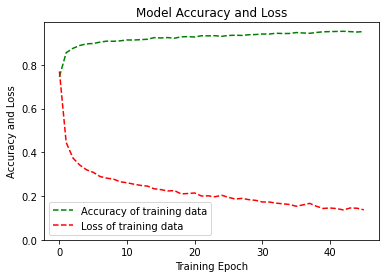

In [19]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [21]:
# Set input_shape / reshape for Keras
# Encode labels
Test_data['encoded_label'] = le.transform(Test_data['broad_mapped_activity'].values.ravel())
print(list(le.classes_))

for i in range(0,6):
    print(data.columns[i])
    Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
    
x_test, y_test = create_segments(Test_data)
print("x shape: ",x_test.shape)
print("y shape: ",y_test.shape)

x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, len(LABELS))
y_test.shape

['Fall', 'Sitting action', 'Walking']
accel_x
mean:  0.011600545010398882
standard deviation:  0.3545680463735675
accel_y
mean:  -0.7946766448383253
standard deviation:  0.4424120958419158
accel_z
mean:  -0.12944676407971234
standard deviation:  0.42574162842799623
gyro_x
mean:  0.10950525352508099
standard deviation:  30.437673283086834
gyro_y
mean:  1.120445297768529
standard deviation:  28.140653634239026
gyro_z
mean:  -0.2428202597866833
standard deviation:  22.231548577342227
x shape:  (6263, 60, 6)
y shape:  (6263,)


(6263, 3)

In [22]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

196/196 [==============================] - 2s 8ms/step - loss: 0.2605 - accuracy: 0.9270

Accuracy on test data: 0.93

Loss on test data: 0.26


In [23]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

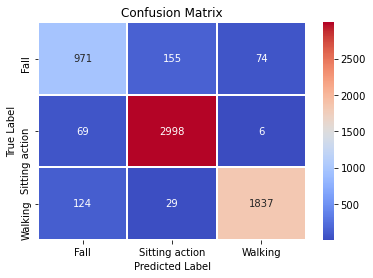


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1200
           1       0.94      0.98      0.96      3073
           2       0.96      0.92      0.94      1990

    accuracy                           0.93      6263
   macro avg       0.91      0.90      0.91      6263
weighted avg       0.93      0.93      0.93      6263



In [24]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [27]:
model_m.save('best_model_cnn.h5')

### LSTM Model

In [28]:
model_lstm = Sequential()
model_lstm.add(LSTM(400, input_shape=(TIME_PERIODS,no_of_features)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(200, activation='relu'))
model_lstm.add(Dense(len(LABELS), activation='softmax'))
print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 400)               651200    
                                                                 
 dropout_2 (Dropout)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               80200     
                                                                 
 dense_4 (Dense)             (None, 3)                 603       
                                                                 
Total params: 732,003
Trainable params: 732,003
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(12530, 60, 6)

In [30]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.Adam(learning_rate=0.001)

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lstm.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
63/63 [==============================] - 12s 118ms/step - loss: 0.7353 - accuracy: 0.7046
Epoch 2/50
63/63 [==============================] - 8s 128ms/step - loss: 0.3747 - accuracy: 0.8731
Epoch 3/50
63/63 [==============================] - 8s 130ms/step - loss: 0.3318 - accuracy: 0.8868
Epoch 4/50
63/63 [==============================] - 8s 129ms/step - loss: 0.3011 - accuracy: 0.8962
Epoch 5/50
63/63 [==============================] - 8s 128ms/step - loss: 0.2760 - accuracy: 0.9060
Epoch 6/50
63/63 [==============================] - 8s 129ms/step - loss: 0.2680 - accuracy: 0.9089
Epoch 7/50
63/63 [==============================] - 23s 372ms/step - loss: 0.2559 - accuracy: 0.9120
Epoch 8/50
63/63 [==============================] - 21s 334ms/step - loss: 0.2423 - accuracy: 0.9151
Epoch 9/50
63/63 [==============================] - 21s 336ms/step - loss: 0.2270 - accuracy: 0.9208
Epoch 10/50
63/63 [==============================] - 21s 335ms/step - loss: 0.2297 - accuracy: 0

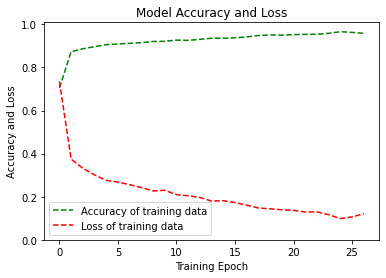

In [31]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [32]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(6263, 60, 6)

In [33]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

196/196 [==============================] - 6s 25ms/step - loss: 0.3555 - accuracy: 0.9104

Accuracy on test data: 0.91

Loss on test data: 0.36


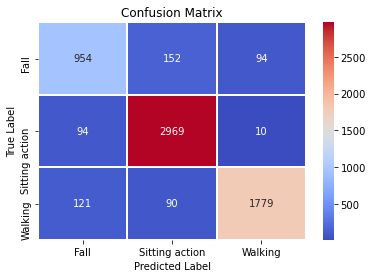


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1200
           1       0.92      0.97      0.94      3073
           2       0.94      0.89      0.92      1990

    accuracy                           0.91      6263
   macro avg       0.90      0.89      0.89      6263
weighted avg       0.91      0.91      0.91      6263



In [34]:
y_pred_test = model_lstm.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [35]:
model_lstm.save('best_model_lstm_online_data.h5')

### 1D CNN + LSTM Model

In [36]:
model_lsnet = Sequential()
model_lsnet.add(Conv1D(100, 3, activation='relu', input_shape=(TIME_PERIODS,no_of_features)))
model_lsnet.add(LSTM(200, return_sequences=True))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(GlobalAveragePooling1D())
model_lsnet.add(Dropout(0.4))
model_lsnet.add(Dense(80, activation='relu'))
model_lsnet.add(Dense(len(LABELS), activation='softmax'))
print(model_lsnet.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 58, 100)           1900      
                                                                 
 lstm_2 (LSTM)               (None, 58, 200)           240800    
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 100)           60100     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 18, 100)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 16, 100)           30100     
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                             

In [37]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(12530, 60, 6)

In [38]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_lsnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lsnet.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
63/63 [==============================] - 21s 229ms/step - loss: 0.9520 - accuracy: 0.5521
Epoch 2/50
63/63 [==============================] - 12s 198ms/step - loss: 0.5205 - accuracy: 0.8142
Epoch 3/50
63/63 [==============================] - 12s 198ms/step - loss: 0.4296 - accuracy: 0.8458
Epoch 4/50
63/63 [==============================] - 12s 198ms/step - loss: 0.4012 - accuracy: 0.8569
Epoch 5/50
63/63 [==============================] - 12s 197ms/step - loss: 0.3873 - accuracy: 0.8614
Epoch 6/50
63/63 [==============================] - 12s 198ms/step - loss: 0.3767 - accuracy: 0.8651
Epoch 7/50
63/63 [==============================] - 13s 199ms/step - loss: 0.3660 - accuracy: 0.8699
Epoch 8/50
63/63 [==============================] - 12s 198ms/step - loss: 0.3549 - accuracy: 0.8758
Epoch 9/50
63/63 [==============================] - 13s 199ms/step - loss: 0.3568 - accuracy: 0.8747
Epoch 10/50
63/63 [==============================] - 12s 198ms/step - loss: 0.3346 - accura

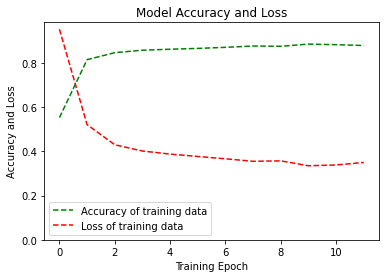

In [39]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [40]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(6263, 60, 6)

In [41]:
score = model_lsnet.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

196/196 [==============================] - 5s 21ms/step - loss: 0.3310 - accuracy: 0.8868

Accuracy on test data: 0.89

Loss on test data: 0.33


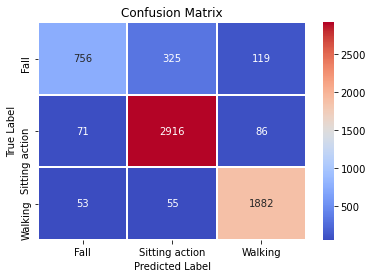


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.86      0.63      0.73      1200
           1       0.88      0.95      0.92      3073
           2       0.90      0.95      0.92      1990

    accuracy                           0.89      6263
   macro avg       0.88      0.84      0.86      6263
weighted avg       0.89      0.89      0.88      6263



In [42]:
y_pred_test = model_lsnet.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [123]:
model_lsnet.save('best_model_lsnet.h5')

### RNN Model

In [79]:
model_rnn = keras.Sequential()
model_rnn.add(Embedding(input_dim=TIME_PERIODS*no_of_features, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model_rnn.add(GRU(128, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.4))
model_rnn.add(Dense(len(LABELS), activation='softmax'))

model_rnn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          23040     
                                                                 
 gru_5 (GRU)                 (None, None, 128)         74496     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 6)                 390       
                                                                 
Total params: 110,278
Trainable params: 110,278
Non-trainable params: 0
_________________________________________________________________


In [80]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(17517, 360)

In [82]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

# opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_rnn.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
88/88 [==============================] - 154s 2s/step - loss: 1.5750 - accuracy: 0.3740
Epoch 2/50
88/88 [==============================] - 144s 2s/step - loss: 1.4819 - accuracy: 0.4450
Epoch 3/50
88/88 [==============================] - 151s 2s/step - loss: 1.4235 - accuracy: 0.4675
Epoch 4/50
88/88 [==============================] - 155s 2s/step - loss: 1.3584 - accuracy: 0.4896
Epoch 5/50
88/88 [==============================] - 155s 2s/step - loss: 1.3501 - accuracy: 0.4891


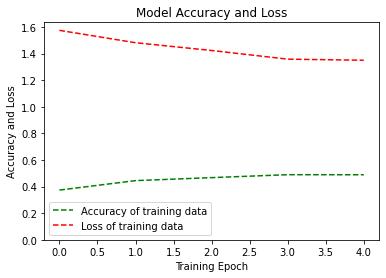

In [83]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [106]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)
x_test.shape

(8723, 360)

In [107]:
score = model_rnn.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

273/273 [==============================] - 28s 99ms/step - loss: 1.2816 - accuracy: 0.5012

Accuracy on test data: 0.50

Loss on test data: 1.28


In [110]:
y_pred_test = model_rnn.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

# Making Predictions

In [32]:
data = pd.read_csv("Sisfall_dataset/processed_data.csv")
data = data[data['activity']!="D18"]
data = data[data['activity']!="D19"]

Test_data = data[data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]

activity = {'Fall': 0, 'Jogging': 1, 'Sitting action': 2, 'Walking': 3, 'climbing stairs': 4, 'getting up': 5}
le = preprocessing.LabelEncoder()
Test_data['encoded_label'] = le.fit_transform(Test_data['broad_mapped_activity'].values.ravel())
print(le.classes_)

mu = [0.012236175547560521, -0.844028325626327, -0.1543912455955434, 0.2556826382272823, 1.5261069734771806, -0.2920010667935128]
sigma = [0.34769250871819196, 0.5536567307930977, 0.42467598155613845, 35.02454787273533, 35.0604674029397, 27.524737149885194]

def normalize_features(data, mu_data, sigma_data):
    return (data - mu_data)/sigma_data

for i in range(0,6):
        Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
        
Test_data = Test_data[100000:105000]
print(Test_data)

x_test_data, y_test_labels = create_segments(Test_data)
print("test data shape: ", x_test_data.shape)

model = keras.models.load_model('best_model_lstm.h5')

x_test_data = x_test_data.astype("float32")

pred = model.predict(x_test_data)
prediction = np.argmax(pred, axis=1)
print("Predictions:", prediction)
print("Actual:", y_test_labels)

['Fall' 'Jogging' 'Sitting action' 'Walking' 'climbing stairs'
 'getting up']
        accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  user activity  \
324002   -0.069   -0.126    0.106   0.214   0.393  -0.612  SA19      F03   
324003    0.111   -0.155    0.216  -0.119   0.762  -0.510  SA19      F03   
324004   -0.406   -0.324    0.483  -0.197   0.883  -0.102  SA19      F03   
324005   -0.833   -0.642    0.538   0.064   0.722  -0.034  SA19      F03   
324006   -0.912   -0.832    0.897   0.411   0.487   0.146  SA19      F03   
...         ...      ...      ...     ...     ...     ...   ...      ...   
336997   -0.878   -0.853   -0.372  -0.699   0.524   1.188  SA21      F04   
336998    0.852   -0.098   -0.676  -0.080   0.035   0.778  SA21      F04   
336999    0.279   -0.500   -0.290  -0.009   0.834   0.370  SA21      F04   
337000   -0.204   -0.035   -0.152   0.181   0.160  -0.227  SA21      F04   
337001   -0.024    0.184    0.023   0.001   0.007  -0.542  SA21      F04   

       ma